1. Import Librabries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

2. Import Data

In [2]:
data = pd.read_csv('data/heart_disease_processed.csv')

print('Shape of data:', data.shape)

Shape of data: (303, 14)


3. Data Preprocessing & Split

In [3]:
X = data.drop('target', axis=1)
y = data['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print('Shape of train set:', X_train.shape,
      '\nShape of test set:', X_test.shape)

Shape of train set: (242, 13) 
Shape of test set: (61, 13)


4. Models & Hyperparameter Tuning

In [4]:
models = {'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
          'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced'),
          'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=sum(y_train==0)/sum(y_train==1))}

param_grids = {'RandomForest': {'n_estimators': [50, 100, 200],
                                'max_depth': [None, 10, 20],
                                'min_samples_split': [2, 3, 5]},
               'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 100],
                                      'max_iter': [1000],
                                      'solver': ['liblinear', 'lbfgs']},
               'XGBoost': {'learning_rate': [0.01, 0.1, 0.3],
                           'max_depth': [3, 5, 7],
                           'n_estimators': [50, 100]}}
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    results.append({'Model': name,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred),
                    'F1': f1_score(y_test, y_pred)})

results_df = pd.DataFrame(results)

results_df

,Model,Accuracy,Precision,Recall,F1
0,RandomForest,0.901639,0.843750,0.964286,0.900000
1,LogisticRegression,0.868852,0.833333,0.892857,0.862069
2,XGBoost,0.852459,0.827586,0.857143,0.842105


5. Model Selection

In [5]:
best_model_name = results_df.loc[results_df['F1'].idxmax(), 'Model']
best_model = best_models[best_model_name]

print(f'The best model: {best_model_name}')

The best model: RandomForest


6. Model Training & Evaluating

In [6]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.9016
Precision: 0.8438
Recall: 0.9643
F1 Score: 0.9000


7. Confusion Matrix

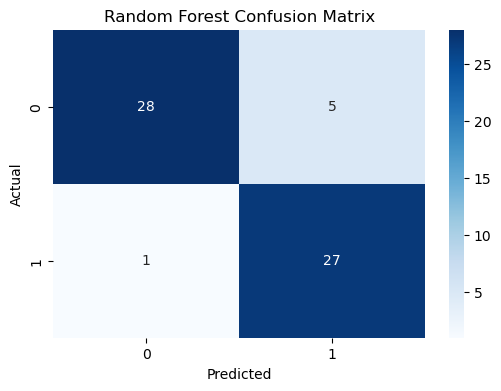

In [7]:
c_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig('figures/confusion_matrix.png')
plt.close()

8. ROC Curve

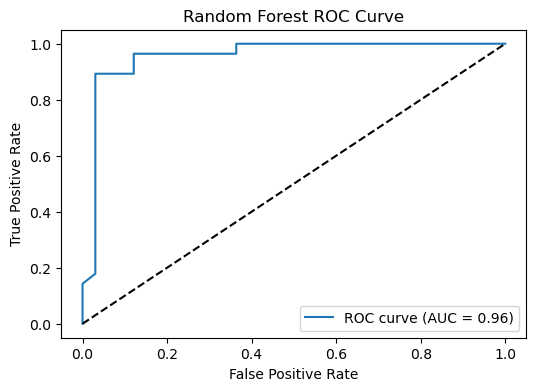

In [8]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()
plt.savefig('figures/roc_curve.png')
plt.close()

9. Feature Importance (For Random Forest)

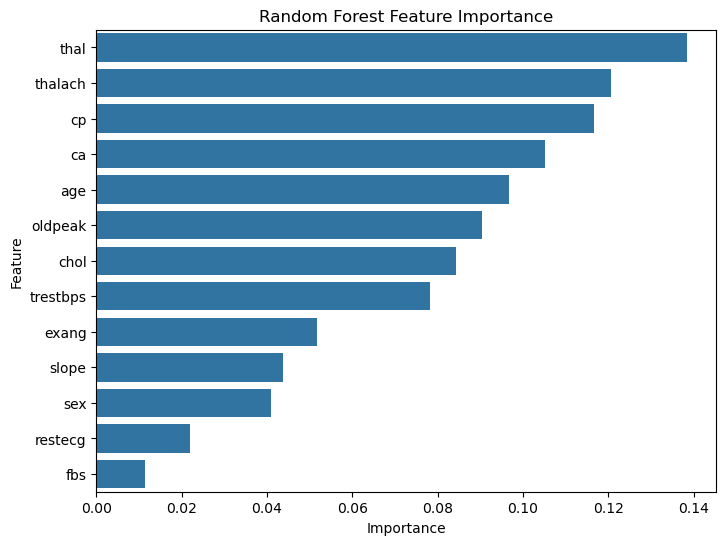

In [9]:
feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title(f'Random Forest Feature Importance')
plt.show()
plt.savefig('figures/feature_importance.png')
plt.close()